In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
fname = "2019-11-11-timings-scipy-pr11031.parquet"
# fname = "2019-11-12-timings-scipy-1.2.0.parquet"

fig_id = fname.replace(".parquet", "").split("-")[-1:]
fig_id = "-".join(fig_id)
print(fig_id)
df = pd.read_parquet(fname)  # long overnight with PR
print(len(df))

pr11031
43250


In [3]:
df.pivot_table(
    columns="ndim", 
    index="mode",
    values="fft_time",
    aggfunc=len
)

ndim,1,2
mode,,
full,7209.0,7209.0
same,7208.0,7208.0
valid,7208.0,7208.0


In [4]:
df["ratio"] = df["auto_time"] / np.minimum(df["fft_time"], df["direct_time"])

In [5]:
df["correct"] = False
idx = (df["choose_conv_method"] == "direct") & (df["direct_time"] < df["fft_time"])
df.loc[idx, "correct"] = True
idx = (df["choose_conv_method"] == "fft") & (df["fft_time"] < df["direct_time"])
df.loc[idx, "correct"] = True

In [6]:
def log_round(x, base=2, decimals=0):
    power = np.log(x) / np.log(base)
    return base ** power.round(decimals=decimals)

kwargs = {"decimals": 1} if len(df) > 10_000 else {"base": 1.3}
df["direct_time_binned"] = log_round(df.direct_time, **kwargs)
print(kwargs)

{'decimals': 1}


In [7]:
df["np_conv"] = ""
idx = (df["mode"] == "same") & (df["ndim"] == 1)
np_conv = idx & (df["x_shape"] <= df["h_shape"])
df.loc[(np_conv & idx), "np_conv"] = "np_conv"
df.loc[((~np_conv) & idx), "np_conv"] = "sp_conv"
df.np_conv

0               
1               
2               
3               
4        np_conv
          ...   
43245           
43246    sp_conv
43247           
43248           
43249           
Name: np_conv, Length: 43250, dtype: object

In [8]:
print(len(df))
df.head()

43250


,x_shape,h_shape,seed,mode,ndim,choose_conv_method,fft_time,direct_time,auto_time,x_shape0,h_shape0,x_shape1,h_shape1,ratio,correct,direct_time_binned,np_conv
0,13.0,8736.0,0,full,1,direct,0.000668,0.000277,0.000300,NaN,NaN,NaN,NaN,1.085345,True,0.000280,
1,NaN,NaN,0,full,2,fft,0.000512,0.076395,0.000455,18.0,42.0,45.0,87.0,0.888268,True,0.076947,
2,13.0,8736.0,0,valid,1,direct,0.000381,0.000183,0.000205,NaN,NaN,NaN,NaN,1.118336,True,0.000185,
3,NaN,NaN,0,valid,2,fft,0.000327,0.014531,0.000326,45.0,18.0,87.0,42.0,0.998541,True,0.014579,
4,13.0,8736.0,0,same,1,fft,0.000341,0.000815,0.000356,NaN,NaN,NaN,NaN,1.043357,True,0.000793,np_conv


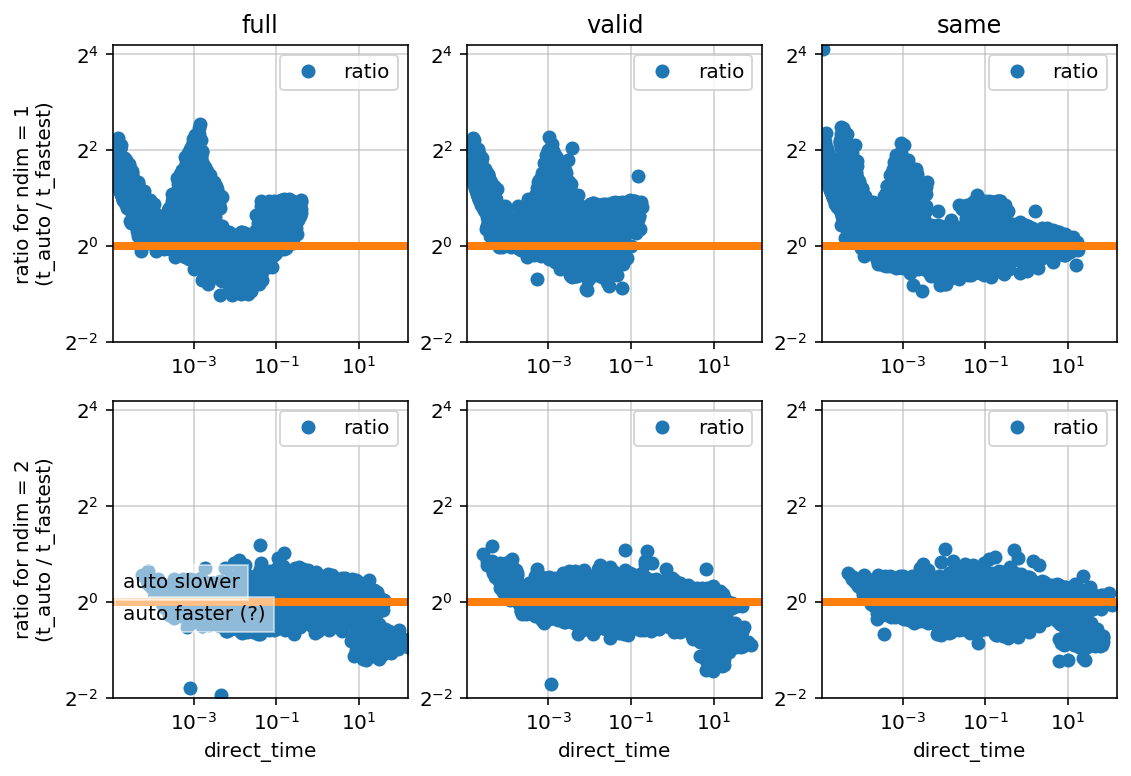

In [9]:
modes = ["full", "valid", "same"]
w = 3
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(3 * w, 2 * w))
for k, mode in enumerate(modes):
    for ndim in [1, 2]:
        idx = (df["mode"] == mode) & (df["ndim"] == ndim)
        show = df[idx]
        ax = show.plot(x="direct_time", y="ratio", style=f"o", ax=axs[ndim - 1][k], alpha=1.0)
        _ = ax.set_yscale("log", basey=2)
        _ = ax.set_xscale("log")
        # _ = ax.text(0.2e-4, 1.25, "method='auto' predict slower method")
        # _ = ax.text(0.2e-4, 1 - 0.25, "method='auto' predict faster method")
        lim = df.ratio.max() + 1
        _ = ax.set_ylim(0.25, lim)
        _ = ax.set_xlim(df.direct_time.min(), df.direct_time.max())
        _ = ax.plot(ax.get_xlim(), [1, 1], linewidth=4)
        _ = ax.grid(alpha=0.6)
        if ndim == 1:
            _ = ax.set_title(mode)
            _ = ax.set_xlabel("")
        if k == 0:
            _ = ax.set_ylabel("ratio for ndim = {}\n(t_auto / t_fastest)".format(ndim))
        if k == 0 and ndim == 2:
            t = ax.text(2e-5, 1.23, "auto slower")
            t.set_bbox(dict(facecolor='white', alpha=0.5, edgecolor='white'))
            t = ax.text(2e-5, 1 - 0.23, "auto faster (?)")
            t.set_bbox(dict(facecolor='white', alpha=0.5, edgecolor='white'))

/Users/scott/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.


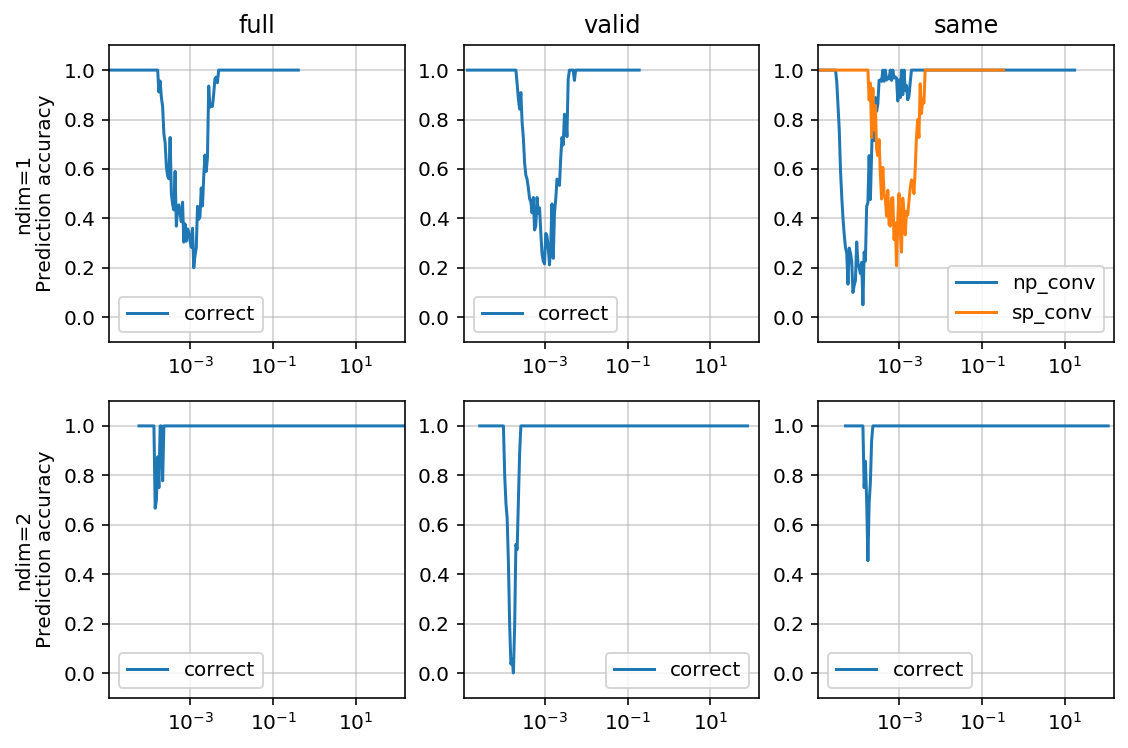

In [10]:
modes = ["full", "valid", "same"]
w = 3
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(3 * w, 2 * w))
for k, mode in enumerate(modes):
    for ndim in [1, 2]:
        idx = (df["mode"] == mode) & (df["ndim"] == ndim)
        s = df[idx]
        for cond in s.np_conv.unique():
            _i = (idx) & (s.np_conv == cond)
            show = s[_i].pivot_table(
                index="direct_time_binned",
                values="correct",
                aggfunc=np.mean,
            )
            kwargs = {"label": cond} if len(s.np_conv.unique()) > 1 else {"label": "correct"}
            ax = axs[ndim - 1][k]
            _ = ax.plot(show, "-",  **kwargs)
            _ = ax.set_xscale("log")
            _ = ax.set_ylim(-0.1, 1.1)
            _ = ax.set_xlim(df.direct_time.min(), df.direct_time.max())
            _ = ax.grid(alpha=0.6)
            _ = ax.legend(loc="best")
            if ndim == 1:
                _ = ax.set_title(mode)
                _ = ax.set_xlabel("")
            if k == 0:
                _ = ax.set_ylabel("ndim={}\nPrediction accuracy".format(ndim))
plt.savefig(f"accuracy-{fig_id}.png")

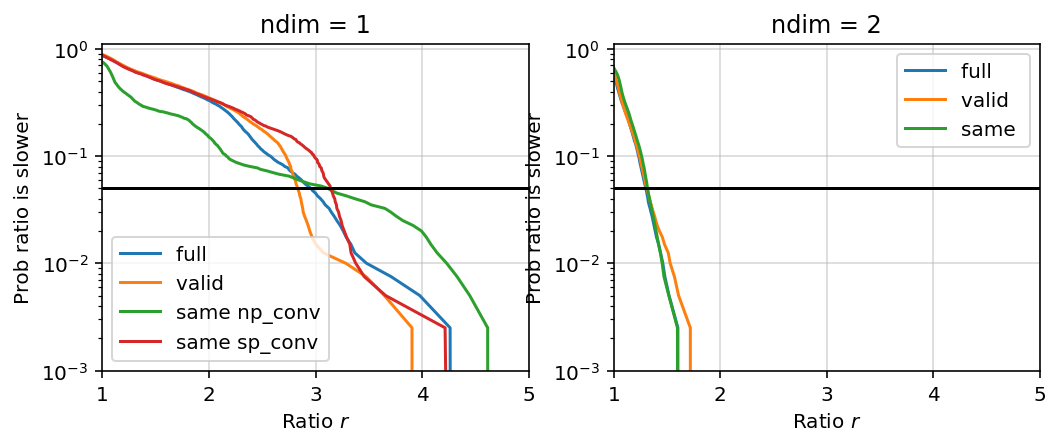

In [11]:
modes = ["full", "valid", "same"]
w = 3
fig, axs = plt.subplots(ncols=2, figsize=(2 * 1.4 * w, 1.0 * w))
for ndim in [1, 2]:
    for k, mode in enumerate(modes):
        idx = (df["mode"] == mode) & (df["ndim"] == ndim)
        show = df[idx]
        for cond in show.np_conv.unique():
            s = show[show.np_conv == cond]
            percentiles = {s.ratio.quantile(q): 1 - q for q in np.linspace(0.00, 1, num=400)}
            s = pd.Series(percentiles)
            ax = axs[ndim - 1]
            kwargs = {"label": mode + " " + cond}
            _ = ax.plot(s, **kwargs)
            _ = ax.set_title(f"ndim = {ndim}");
            _ = ax.set_xlabel("Ratio $r$")
            _ = ax.set_ylabel("Prob ratio is slower")
            _ = ax.set_xlim(1, 5)
            _ = ax.set_xlim(1, None)
            if True:
                _ = ax.set_yscale("log")
                _ = ax.set_ylim(1e-3, 1.1)

            _ = ax.grid(alpha=0.5)
            _ = ax.legend(loc="best")
            _ = ax.plot(ax.get_xlim(), [0.05, 0.05], "black")
#             _ = ax.set_ylim(0, 0.1)
plt.savefig(f"ratio-{fig_id}.png")

In [12]:
df[df["ndim"] == 1].groupby("mode")["x_shape"].min()

mode
full     3.0
same     3.0
valid    3.0
Name: x_shape, dtype: float64

In [13]:
df[df["ndim"] == 1].groupby("mode")["h_shape"].min()

mode
full     3.0
same     3.0
valid    3.0
Name: h_shape, dtype: float64